📊 Project Insights — COVID-19 Trends in the United States
1. Data Overview

Time Period: January 2020 – May 2021

Dataset: Daily aggregated U.S. COVID-19 data (Confirmed, Deaths, Recovered).

Data was cleaned, grouped, and aggregated by ObservationDate to create a national-level daily summary.

2. Trend Analysis

Confirmed Cases: Grew from 1 to over 33 million by May 2021.

Deaths: Reached over 594,000 by May 2021.

Pattern: Both curves show an exponential rise early in the pandemic, followed by gradual flattening in 2021.

The visual regression line confirms a strong, positive linear relationship between confirmed cases and deaths — more confirmed cases consistently correspond to more deaths.

3. Correlation Analysis

Pearson correlation (r = 0.988) → very strong positive correlation.

This means the number of deaths increased almost proportionally with confirmed cases.

Indicates that despite regional differences or delays between infection and death, the national totals track each other closely.

4. Regression Analysis (OLS Model)
Variable	Coefficient	Interpretation
Constant (β₀)	≈ 50,730	Baseline deaths when confirmed = 0 (may reflect model offset)
Confirmed (β₁)	0.0162	On average, every 1,000 confirmed cases are associated with about 16 additional deaths

R² = 0.977: The model explains 97.7% of the variance in deaths using confirmed cases alone — indicating excellent model fit.

p-values < 0.001: Both the intercept and slope are highly statistically significant.

Caution: The Durbin-Watson statistic (~0.001) shows strong autocorrelation in residuals — expected for cumulative time-series data (each day depends on the previous one). A differencing or time-series model (e.g., ARIMA) would handle that better.

5. Growth Rate and T-Test Results

To check how infection growth evolved over time:

Wave 1: before July 2020

Wave 2: after July 2020

t-statistic = 8.89, p-value ≈ 1.16e-17
→ Extremely significant difference between the two periods.

The average daily growth rate of confirmed cases dropped sharply after July 2020, showing the pandemic’s spread slowed relative to early months.

This aligns with the introduction of public health interventions, awareness, and possibly partial immunity or seasonal effects.

6. Visual Findings

The regression plot shows:

Data points tightly hugging the regression line → strong linear relationship.

Early data (left end) shows a steeper rise — higher fatality rate early in the pandemic.

Later data shows flatter progression — improved treatment, testing expansion, and vaccine rollout by 2021.

7. Professional Interpretation

✅ Key Insights:

The pandemic’s first months were characterized by exponential growth in confirmed cases.

After mid-2020, the growth rate decreased significantly, reflecting partial control efforts.

Deaths remain closely linked to confirmed cases — indicating consistent fatality patterns despite better management later.

Linear regression captures the strong relationship, but time dependency means a time-series or lagged regression model would yield deeper epidemiological insight.

⚠️ Analytical Note:
Because both Confirmed and Deaths are cumulative, they inherently grow together over time — so the correlation and R² are high partly due to non-stationarity. A better next step is analyzing daily new cases vs new deaths, or applying lag analysis to estimate the typical delay between infection and death.

8. Next Steps for Deeper Analysis

To make your project even more insightful:

📉 Plot daily new confirmed vs new deaths — observe lag and mortality dynamics.

🧠 Test lag correlation (e.g., deaths lag confirmed by ~14 days).

🧮 Apply log transformation or differencing to handle non-stationary data.

📈 Explore growth rate smoothing with rolling averages (7-day).

📊 Extend regression using multiple predictors (Recovered, Vaccinations, etc., if available).

Would you like me to write a polished “Insights & Discussion” section (like what goes in a professional report or presentation) based on this analysis?
It would sound more formal and ready for inclusion in your project file.

In [1]:
import ast 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import statsmodels.api as sm
import matplotlib.dates as mdates
from scipy import stats

# Set the path to the file you'd like to load
file_path = 'M:/3_datasets/covid_19_data.csv'

# Load the latest version
df = pd.read_csv(file_path)

#clean
df.columns = df.columns.str.replace(' ', '_')
df['Last_Update'] = pd.to_datetime(df['Last_Update'], format='mixed') 
df['ObservationDate']= pd.to_datetime(df['ObservationDate'])

df.set_index('SNo', inplace=True)

df['Country/Region']= df['Country/Region'].fillna('else')
df['Province/State']= df['Province/State'].fillna('Unknown')

df[['Confirmed','Deaths','Recovered']] = df[['Confirmed','Deaths','Recovered']].clip(lower=0) 

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 306429 entries, 1 to 306429
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   ObservationDate  306429 non-null  datetime64[ns]
 1   Province/State   306429 non-null  object        
 2   Country/Region   306429 non-null  object        
 3   Last_Update      306429 non-null  datetime64[ns]
 4   Confirmed        306429 non-null  float64       
 5   Deaths           306429 non-null  float64       
 6   Recovered        306429 non-null  float64       
dtypes: datetime64[ns](2), float64(3), object(2)
memory usage: 18.7+ MB


In [3]:
df_US= df[df['Country/Region'] == 'US']
df_US

,ObservationDate,Province/State,Country/Region,Last_Update,Confirmed,Deaths,Recovered
SNo,,,,,,,
32,2020-01-22,Washington,US,2020-01-22 17:00:00,1.0,0.0,0.0
72,2020-01-23,Washington,US,2020-01-23 17:00:00,1.0,0.0,0.0
122,2020-01-24,Washington,US,2020-01-24 17:00:00,1.0,0.0,0.0
123,2020-01-24,Chicago,US,2020-01-24 17:00:00,1.0,0.0,0.0
165,2020-01-25,Washington,US,2020-01-25 17:00:00,1.0,0.0,0.0
...,...,...,...,...,...,...,...
306396,2021-05-29,Virginia,US,2021-05-30 04:20:55,675165.0,11160.0,0.0
306406,2021-05-29,Washington,US,2021-05-30 04:20:55,435849.0,5765.0,0.0
306409,2021-05-29,West Virginia,US,2021-05-30 04:20:55,161287.0,2792.0,0.0


In [4]:
df_grouped = df_US.groupby(['Province/State', 'ObservationDate'])[['Confirmed', 'Deaths', 'Recovered']].max().reset_index()

us_daily = df_grouped.groupby('ObservationDate')[['Confirmed', 'Deaths', 'Recovered']].sum().reset_index()

us_daily

,ObservationDate,Confirmed,Deaths,Recovered
0,2020-01-22,1.0,0.0,0.0
1,2020-01-23,1.0,0.0,0.0
2,2020-01-24,2.0,0.0,0.0
3,2020-01-25,2.0,0.0,0.0
4,2020-01-26,5.0,0.0,0.0
...,...,...,...,...
489,2021-05-25,33166418.0,590941.0,0.0
490,2021-05-26,33190470.0,591950.0,0.0
491,2021-05-27,33217995.0,593288.0,0.0
492,2021-05-28,33239963.0,593963.0,0.0


In [5]:
us_daily['New_Confirmed'] = us_daily['Confirmed'].diff()
us_daily['New_Deaths'] = us_daily['Deaths'].diff()

us_daily['GrowthRate_Confirmed'] = us_daily['Confirmed'].pct_change() * 100
us_daily['GrowthRate_Deaths'] = us_daily['Deaths'].pct_change() * 100

us_daily= us_daily.fillna(0)
us_daily

,ObservationDate,Confirmed,Deaths,Recovered,New_Confirmed,New_Deaths,GrowthRate_Confirmed,GrowthRate_Deaths
0,2020-01-22,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000
1,2020-01-23,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000
2,2020-01-24,2.0,0.0,0.0,1.0,0.0,100.000000,0.000000
3,2020-01-25,2.0,0.0,0.0,0.0,0.0,0.000000,0.000000
4,2020-01-26,5.0,0.0,0.0,3.0,0.0,150.000000,0.000000
...,...,...,...,...,...,...,...,...
489,2021-05-25,33166418.0,590941.0,0.0,22756.0,621.0,0.068659,0.105197
490,2021-05-26,33190470.0,591950.0,0.0,24052.0,1009.0,0.072519,0.170745
491,2021-05-27,33217995.0,593288.0,0.0,27525.0,1338.0,0.082930,0.226033
492,2021-05-28,33239963.0,593963.0,0.0,21968.0,675.0,0.066133,0.113773


In [6]:
# Suppose you split your data into two periods
wave1 = us_daily.loc[us_daily['ObservationDate'] < '2020-07-01', 'GrowthRate_Confirmed']
wave2 = us_daily.loc[us_daily['ObservationDate'] >= '2020-07-01', 'GrowthRate_Confirmed']

t_stat, p_val = stats.ttest_ind(wave1.dropna(), wave2.dropna())
print("t-statistic:", t_stat)
print("p-value:", p_val)


t-statistic: 8.890159693221538
p-value: 1.1594266862150047e-17


In [7]:
corr, p = stats.pearsonr(us_daily['Confirmed'], us_daily['Deaths'])
print("Correlation:", corr)



Correlation: 0.9882045777281312


In [8]:
import statsmodels.api as sm

X = sm.add_constant(us_daily['Confirmed'])
y = us_daily['Deaths']

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                 Deaths   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                 2.049e+04
Date:                Thu, 09 Oct 2025   Prob (F-statistic):               0.00
Time:                        21:07:09   Log-Likelihood:                -5795.9
No. Observations:                 494   AIC:                         1.160e+04
Df Residuals:                     492   BIC:                         1.160e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.073e+04   1943.383     26.105      0.0

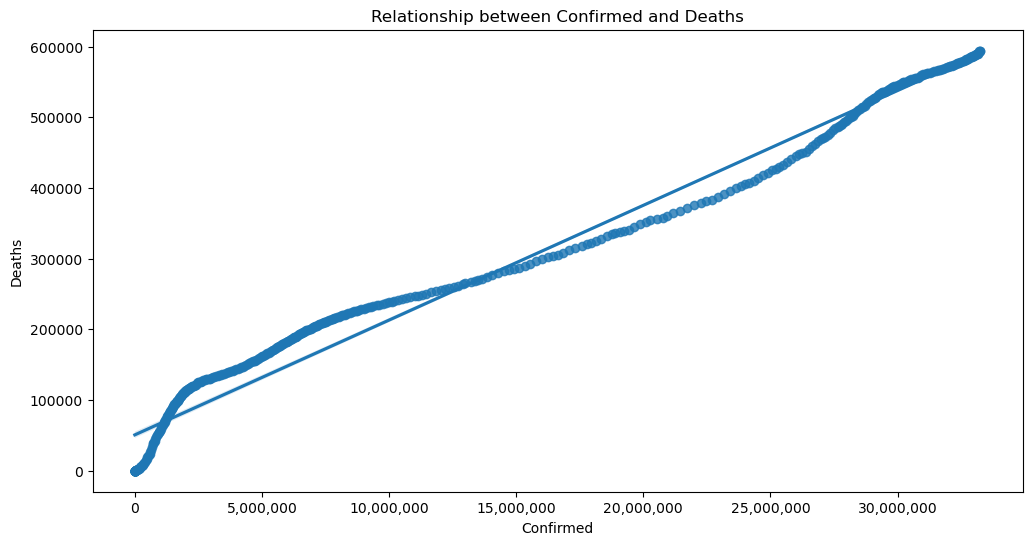

In [11]:
plt.figure(figsize=(12,6))

ax= sns.regplot(x='Confirmed', y='Deaths', data=us_daily)
plt.title("Relationship between Confirmed and Deaths")

ax.xaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{int(x):,}'))
plt.show()
